In [1]:
from simple_foraging_env import SimpleForagingEnv, SimpleAgent, RandomAgent, ZigZagAgent
from opponent_model import OpponentModel, SubGoalSelector
from opponent_model_oracle import OpponentModelOracle
from q_agent import QLearningAgent, ReplayBuffer
from q_agent_classic import QLearningAgentClassic
from omg_args import OMGArgs
import transformers as t
import matplotlib.pyplot as plt
import torch
import os
import random
import numpy as np
from collections import deque
from typing import Deque, Dict, List, Tuple, Optional

In [2]:
from experiments.om import q_agent
from experiments.om import q_agent_classic

env = SimpleForagingEnv(grid_size=7, max_steps=30)

obs_sample = env.reset()[0]
H, W, F_dim = obs_sample.shape
NUM_ACTIONS = 4

args = OMGArgs(
  device="cpu",
  folder_id="0",
  batch_size=128,
  horizon_H=6,
  qnet_hidden=256,
  max_steps=30,
  selector_mode="conservative",
  vae_beta=0.1,
  beta_start=1.0,
  beta_end=2.0,
  selector_tau_start=2.0,
  selector_tau_end=0.1,
  state_shape=obs_sample.shape,
  H=H, W=W,
  state_feature_splits=(F_dim,),
  action_dim=NUM_ACTIONS,
  latent_dim=32,
  d_model=256,
  nhead=4,
  num_encoder_layers=1,
  num_decoder_layers=1,
  dim_feedforward=1024,
  dropout=0.1,
)

os.makedirs("./diagrams_0", exist_ok=True)

vae = t.TransformerVAE(args)
cvae = t.TransformerCVAE(args)
# vae.load_state_dict(torch.load('./models_0/vae.pth', map_location=args.device))
# cvae.load_state_dict(torch.load('./models_0/cvae.pth', map_location=args.device))
selector = SubGoalSelector(args)

# op_model = OpponentModel(
#   cvae, vae, selector, args=args)
op_model = OpponentModelOracle(cvae, vae, selector, args=args)
q_agent = QLearningAgent(
    env=env,
    opponent_model=op_model,
    args=args
)
q_agent_classic = QLearningAgentClassic(
    env=env,
    args=args
)
q_agent.q.load_state_dict(torch.load('./models_0/qnet_oracle.pth', map_location=args.device))
q_agent_classic.q.load_state_dict(torch.load('./models_0/qnet_classic.pth', map_location=args.device))

<All keys matched successfully>

In [3]:
projector = torch.tensor([ 1.6279,  0.8230, -0.7939,  0.6464,  0.5263, -1.4681, -1.0036, -0.3662,
        -0.0999, -0.1288, -1.7812, -1.1658,  1.0659, -0.2044,  0.2153, -0.0620,
         2.0432, -1.4007,  0.8343,  0.4439, -0.4482,  1.2086, -1.0056,  0.2771,
        -0.5053,  1.0932, -0.8953,  0.2138,  0.5949, -0.7294,  1.4238, -1.6386]) # paste here
q_agent.model.projector = projector

. . . F . . .
. . . . . . .
. . . . . . .
A . . . . . B
. . . . . . .
. . . . . . .
. . . F . . .

. . . F . . .
. . . . . . .
. . . . . . .
. A . . . B .
. . . . . . .
. . . . . . .
. . . F . . .

. . . F . . .
. . . . . . .
. . . . . . .
. . A . . . .
. . . . . B .
. . . . . . .
. . . F . . .

. . . F . . .
. . . . . . .
. . . . . . .
. . . A . . .
. . . . B . .
. . . . . . .
. . . F . . .

. . . F . . .
. . . . . . .
. . . . . . .
. . A . . . .
. . . . . . .
. . . . B . .
. . . F . . .

. . . F . . .
. . . . . . .
. . A . . . .
. . . . . . .
. . . . . . .
. . . B . . .
. . . F . . .

. . . F . . .
. . A . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . B . . .

. . A F . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . B . . .
. . . . . . .

. . A F . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . B . . .
. . . . . . .
. . . . . . .

. . A F . . .
. . . . . . .
. . . . . . .
. . . B . . .
. . . . . . .
. . . . . . .
. . . . . . .

. . A F . 

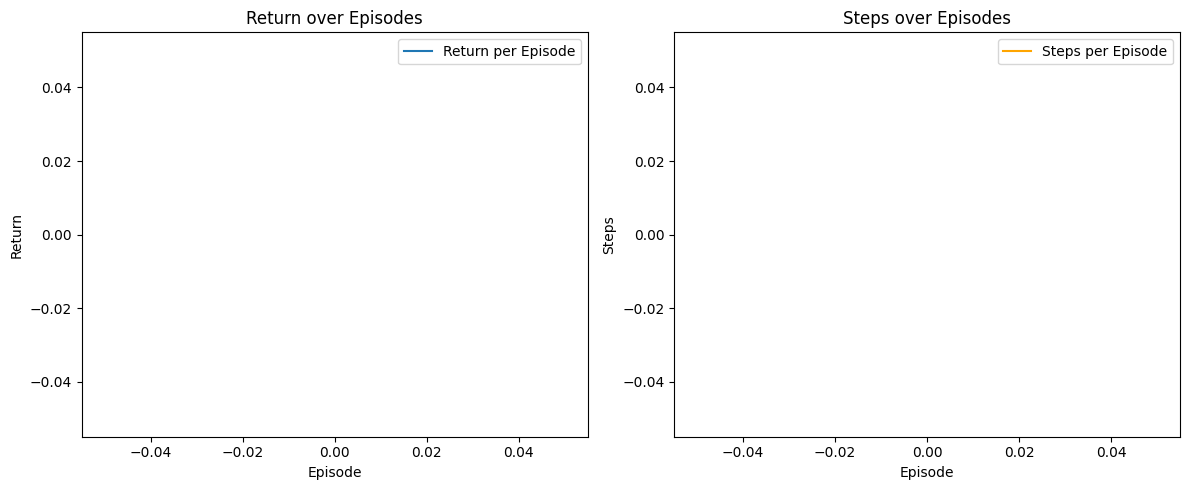

In [ ]:
# run test episodes of q_agent and make final graph of the rewards
max_len = 100
return_list = []
tmp_returns = deque(maxlen=max_len)
steps_list = []
tmp_steps: Deque[int] = deque(maxlen=max_len)
episode_list = []
for step in range(5):
  info = q_agent.run_test_episode(zigzag=False, render=False)
  tmp_returns.append(info["return"])
  tmp_steps.append(info["steps"])
  if (step + 1) % 10 == 0:
    episode_list.append(step + 1)
    return_list.append(np.mean(tmp_returns))
    steps_list.append(np.mean(tmp_steps))
    # print(f"Episode {step + 1}: Average Return: {return_list[-1]}, Average Steps: {steps_list[-1]}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(episode_list, return_list, label='Return per Episode')
plt.xlabel('Episode')
plt.ylabel('Return')
plt.title('Return over Episodes')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(episode_list, steps_list, label='Steps per Episode', color='orange')
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.title('Steps over Episodes')
plt.legend()
plt.tight_layout()
# plt.savefig(f"./diagrams_{args.folder_id}/test_oracle_zig.png")
plt.show()

. . . F . . .
. . . . . . .
. . . . . . .
A . . . . . B
. . . . . . .
. . . . . . .
. . . F . . .

. . . F . . .
. . . . . . .
. . . . . . .
. A . . . B .
. . . . . . .
. . . . . . .
. . . F . . .

. . . F . . .
. . . . . . .
. . . . . . .
. . A . . . .
. . . . . B .
. . . . . . .
. . . F . . .

. . . F . . .
. . . . . . .
. . . . . . .
. . . A . . .
. . . . B . .
. . . . . . .
. . . F . . .

. . . F . . .
. . . . . . .
. . . A . . .
. . . . . . .
. . . . . . .
. . . . B . .
. . . F . . .

. . . F . . .
. . . A . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . B . . .
. . . F . . .

. . . F . . .
. . . . . . .
. . . . . . .
A . . . . . B
. . . . . . .
. . . . . . .
. . . F . . .

. . . F . . .
. . . . . . .
. . . . . . .
. A . . . B .
. . . . . . .
. . . . . . .
. . . F . . .

. . . F . . .
. . . . . . .
. . . . . B .
. . A . . . .
. . . . . . .
. . . . . . .
. . . F . . .

. . . F . . .
. . . . . . .
. . A . B . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . F . . .

. . . F . 

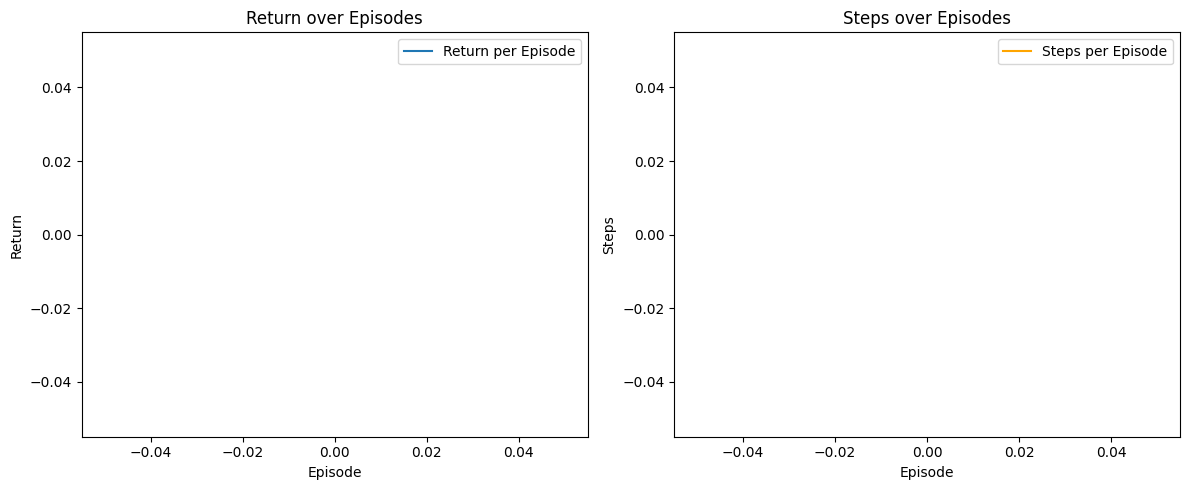

In [9]:
# run test episodes of q_agent_classic and make final graph of the rewards
max_len = 100
return_list = []
tmp_returns = deque(maxlen=max_len)
steps_list = []
tmp_steps: Deque[int] = deque(maxlen=max_len)
episode_list = []
for step in range(3):
  info = q_agent_classic.run_test_episode(zigzag=True, render=True)
  tmp_returns.append(info["return"])
  tmp_steps.append(info["steps"])
  if (step + 1) % 10 == 0:
    episode_list.append(step + 1)
    return_list.append(np.mean(tmp_returns))
    steps_list.append(np.mean(tmp_steps))
    # print(f"Episode {step + 1}: Average Return: {return_list[-1]}, Average Steps: {steps_list[-1]}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(episode_list, return_list, label='Return per Episode')
plt.xlabel('Episode')
plt.ylabel('Return')
plt.title('Return over Episodes')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(episode_list, steps_list, label='Steps per Episode', color='orange')
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.title('Steps over Episodes')
plt.legend()
plt.tight_layout()
# plt.savefig(f"./diagrams_{args.folder_id}/test_classic_zig.png")
plt.show()